## Types of Plagiarism

Each text file is associated with one **Task** (task A-E) and one **Category** of plagiarism, which you can see in the above DataFrame.

###  Tasks, A-E

Each text file contains an answer to one short question; these questions are labeled as tasks A-E. For example, Task A asks the question: "What is inheritance in object oriented programming?"

### Categories of plagiarism 

Each text file has an associated plagiarism label/category:

**1. Plagiarized categories: `cut`, `light`, and `heavy`.**
* These categories represent different levels of plagiarized answer texts. `cut` answers copy directly from a source text, `light` answers are based on the source text but include some light rephrasing, and `heavy` answers are based on the source text, but *heavily* rephrased (and will likely be the most challenging kind of plagiarism to detect).
     
**2. Non-plagiarized category: `non`.** 
* `non` indicates that an answer is not plagiarized; the Wikipedia source text is not used to create this answer.
    
**3. Special, source text category: `orig`.**
* This is a specific category for the original, Wikipedia source text. We will use these files only for comparison purposes.

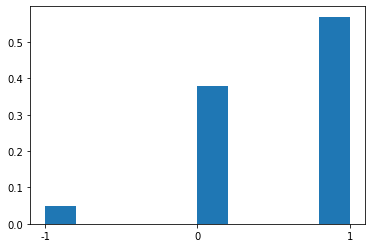

In [223]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import yake
from sklearn import svm
import sklearn.ensemble

csv_file = 'data/file_information.csv'
plagiarism_df = pd.read_csv(csv_file)

# print out the first rows of data info
plagiarism_df.head()
def addPlagiarismClass(category):
    if category == -1:
        return -1
    elif  category == 0:
        return 0
    else:
        return 1

dictPlagiarismToInt= { "non": 0,"heavy": 1,"light": 2,"cut" : 3, "orig":-1}                                                        
plagiarism_df['Category'] = plagiarism_df['Category'].apply(lambda x: dictPlagiarismToInt[x])
plagiarism_df['Class'] = plagiarism_df['Category'].apply(lambda x: addPlagiarismClass(x))


plt.hist(sorted(plagiarism_df.Class.astype(str)),weights=np.ones(len(plagiarism_df.Class)) / len(plagiarism_df.Class))
# check work
# check that all categories of plagiarism have a class label = 1
plagiarism_df.head(10)
import helpers 

# create a text column 
plagiarism_df = helpers.create_text_column(plagiarism_df)
plagiarism_df['Length'] = plagiarism_df['Text'].apply(lambda x: len(x))

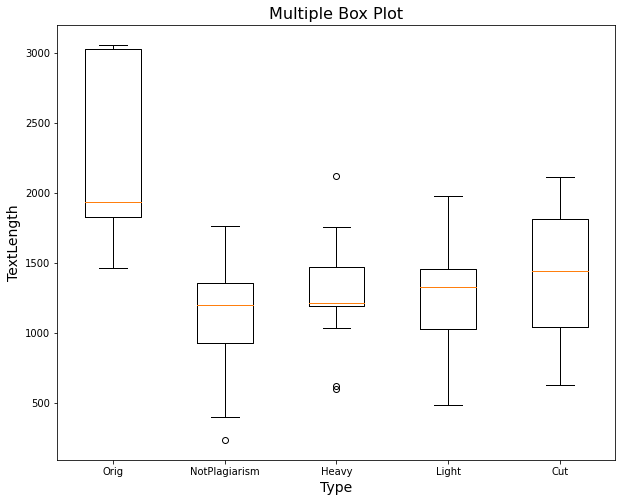

In [224]:
orig = plagiarism_df[plagiarism_df['Category']==-1]
notPlag = plagiarism_df[plagiarism_df['Category']==0]
heavy = plagiarism_df[plagiarism_df['Category']==1]
light = plagiarism_df[plagiarism_df['Category']==2]
cut = plagiarism_df[plagiarism_df['Category']==3]


data = [orig.Length,notPlag.Length,heavy.Length,light.Length,cut.Length]
labels = ['Orig','NotPlagiarism','Heavy','Light','Cut']
# plot the figure
plt.figure(figsize=(10, 8))
plt.boxplot(data, labels=labels)
plt.title("Multiple Box Plot", fontsize=16)
plt.xlabel("Type", fontsize=14)
plt.ylabel("TextLength", fontsize=14)
plt.savefig("box_mat6")
plt.show()

C:\Users\alnar\AppData\Local\Temp\ipykernel_21116\3278812859.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plag['nGrams'] = plag.apply(lambda x: ComputeNGrams(x['Text'],orig[orig['Task'] == x['Task']]),1)


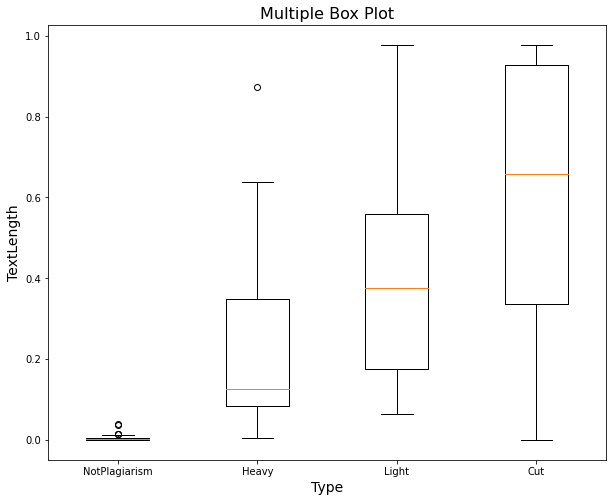

In [226]:
plagiarism_df = helpers.train_test_dataframe(plagiarism_df, random_seed=1)

plag = plagiarism_df[plagiarism_df['Category']!=-1]
orig = plagiarism_df[plagiarism_df['Category']==-1]
#print(plag.Task)
#plag.apply(lambda x: print(x.Task),1)
def ComputeNGrams(textPlag,orig):
    textPlag = [textPlag]
    textOrig = [orig.iloc[0].Text]
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(4, 4))
    vectorizer.fit_transform(textPlag)
    n_gramAnswer = set(vectorizer.get_feature_names_out())

    vectorizerOrig = CountVectorizer(analyzer='word', ngram_range=(4, 4))
    vectorizerOrig.fit_transform(textOrig)
    n_gramOrig = set(vectorizerOrig.get_feature_names_out())

    intersection = n_gramAnswer.intersection(n_gramOrig)
    return len(intersection) / len(n_gramAnswer)

plag['nGrams'] = plag.apply(lambda x: ComputeNGrams(x['Text'],orig[orig['Task'] == x['Task']]),1)


notPlag = plag[plag['Category']==0]
heavy = plag[plag['Category']==1]
light = plag[plag['Category']==2]
cut = plag[plag['Category']==3]

data = [notPlag.nGrams,heavy.nGrams,light.nGrams,cut.nGrams]
labels = ['NotPlagiarism','Heavy','Light','Cut']

plt.figure(figsize=(10, 8))
plt.boxplot(data, labels=labels)
plt.title("Multiple Box Plot", fontsize=16)
plt.xlabel("Type", fontsize=14)
plt.ylabel("TextLength", fontsize=14)
plt.savefig("box_mat6")
plt.show()

C:\Users\alnar\AppData\Local\Temp\ipykernel_21116\1297169597.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plag['Lcs'] = plag.apply(lambda x: lcs_norm_word(x['Text'],orig[orig['Task'] == x['Task']]),1)


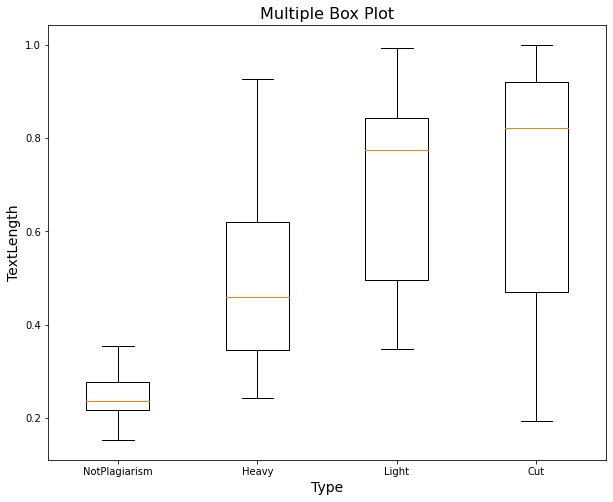

In [227]:
def lcs_norm_word(textPlag,orig):
    '''Computes the longest common subsequence of words in two texts; returns a normalized value.
       :param answer_text: The pre-processed text for an answer text
       :param source_text: The pre-processed text for an answer's associated source text
       :return: A normalized LCS value'''
    
   #Create the matrix with an extra row based on source_text and an extra col based on answer_text
    textOrig = orig.iloc[0].Text

    answerWords = textPlag.split()
    sourceWords = textOrig.split()
    rowNum = len(answerWords) + 1
    colNum = len(sourceWords) + 1
    zeors_array = np.zeros( (colNum ,rowNum ),dtype=object )
    
    
    for i,let in enumerate(answerWords):
        zeors_array[0][i+1] = answerWords[i]
      
    for i,let in enumerate(sourceWords):
        zeors_array[i+1][0] = sourceWords[i]
        
    for i,col in enumerate(sourceWords):
        for j,row in enumerate(answerWords):
            if (row == col):
                if (j > 0):
                    if (i > 0):
                        zeors_array[i+1][j+1] = zeors_array[i][j] + 1
                    else:
                        zeors_array[i+1][j+1] = zeors_array[i+1][j] + 1
                else:
                    zeors_array[i+1][j+1]  = 1
            else:
                if (j > 0):
                    if (i > 0):
                        zeors_array[i+1][j+1] =  zeors_array[i][j+1] if(  zeors_array[i][j+1] >  zeors_array[i+1][j]) else zeors_array[i+1][j]
                    else:
                        zeors_array[i+1][j+1] = zeors_array[i+1][j]
                
            
    return  zeors_array [colNum-1][rowNum-1] / len(answerWords)


plag['Lcs'] = plag.apply(lambda x: lcs_norm_word(x['Text'],orig[orig['Task'] == x['Task']]),1)
notPlag = plag[plag['Category']==0]
heavy = plag[plag['Category']==1]
light = plag[plag['Category']==2]
cut = plag[plag['Category']==3]

data = [notPlag.Lcs,heavy.Lcs,light.Lcs,cut.Lcs]
labels = ['NotPlagiarism','Heavy','Light','Cut']

plt.figure(figsize=(10, 8))
plt.boxplot(data, labels=labels)
plt.title("Multiple Box Plot", fontsize=16)
plt.xlabel("Type", fontsize=14)
plt.ylabel("TextLength", fontsize=14)
plt.savefig("box_mat6")
plt.show()

In [228]:
def ComputeCommonKeyWords(textPlag,orig):
  textOrig = orig.iloc[0].Text
  kw_extractor = yake.KeywordExtractor(top=15, stopwords=None,n=1)
  keywordsPlag = kw_extractor.extract_keywords(textPlag)
  keywordsOrig = kw_extractor.extract_keywords(textOrig)

  keywordsPlag = [x[0] for x in keywordsPlag]
  keywordsOrig = [x[0] for x in keywordsOrig]

  return len(set(keywordsPlag).intersection(set(keywordsOrig)))/15
  
plag['KeyWord'] = plag.apply(lambda x: ComputeCommonKeyWords(x['Text'],orig[orig['Task'] == x['Task']]),1)
plag.head()

C:\Users\alnar\AppData\Local\Temp\ipykernel_21116\1534796477.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plag['KeyWord'] = plag.apply(lambda x: ComputeCommonKeyWords(x['Text'],orig[orig['Task'] == x['Task']]),1)


,File,Task,Category,Class,Text,Length,Datatype,nGrams,Lcs,KeyWord
0,g0pA_taska.txt,a,0,0,inheritance is a basic concept of object orien...,1348,train,0.000000,0.191781,0.200000
1,g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by ...,1218,test,0.943299,0.820755,0.600000
2,g0pA_taskc.txt,c,2,1,the vector space model also called term vector...,1367,train,0.520737,0.846491,0.933333
3,g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas bayes...,1212,train,0.109290,0.316062,0.400000
4,g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design tec...,1232,train,0.005319,0.242574,0.466667


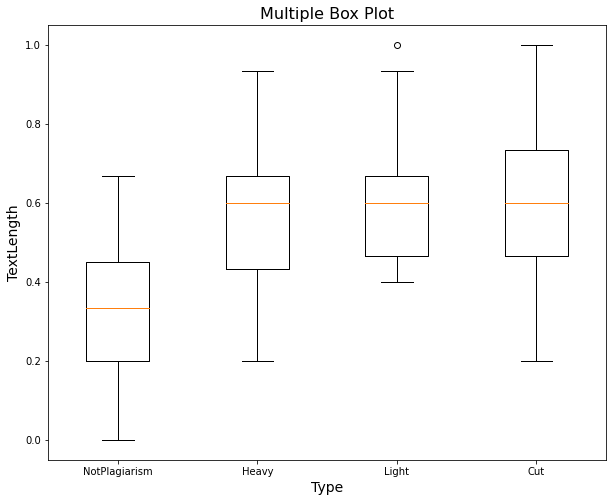

In [229]:
notPlag = plag[plag['Category']==0]
heavy = plag[plag['Category']==1]
light = plag[plag['Category']==2]
cut = plag[plag['Category']==3]

data = [notPlag.KeyWord,heavy.KeyWord,light.KeyWord,cut.KeyWord]
labels = ['NotPlagiarism','Heavy','Light','Cut']

plt.figure(figsize=(10, 8))
plt.boxplot(data, labels=labels)
plt.title("Multiple Box Plot", fontsize=16)
plt.xlabel("Type", fontsize=14)
plt.ylabel("TextLength", fontsize=14)
plt.savefig("box_mat6")
plt.show()

In [230]:
dsForCorr = plag[['Length','nGrams','Lcs','KeyWord']]
# Create correlation matrix for just Features to determine different models to test
corr_matrix = dsForCorr.corr().abs().round(2)

# display shows all of a dataframe
display(corr_matrix)

,Length,nGrams,Lcs,KeyWord
Length,1.00,0.24,0.13,0.37
nGrams,0.24,1.00,0.93,0.65
Lcs,0.13,0.93,1.00,0.69
KeyWord,0.37,0.65,0.69,1.00


In [231]:
nCols = plag.shape[1] -1
column_to_move = plag.pop("Class")
plag.insert(nCols, "Class", column_to_move)
plag.drop('File',inplace=True,axis = 1)
plag.drop('Text',inplace=True,axis = 1)
plag.drop('Task',inplace=True,axis = 1)
plag.drop('Category',inplace=True,axis = 1)

trainDataSet = plag[plag['Datatype']=='train']
testDataSet = plag[plag['Datatype'] !='train']
trainDataSet.drop('Datatype',inplace=True,axis = 1)
testDataSet.drop('Datatype',inplace=True,axis = 1)

C:\Users\alnar\AppData\Local\Temp\ipykernel_21116\641850306.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plag.drop('File',inplace=True,axis = 1)
C:\Users\alnar\AppData\Local\Temp\ipykernel_21116\641850306.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plag.drop('Text',inplace=True,axis = 1)
C:\Users\alnar\AppData\Local\Temp\ipykernel_21116\641850306.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plag.drop('Task',inplac

In [233]:
nCols = trainDataSet.shape[1] -1
train_X = trainDataSet.iloc[:, 0:nCols]
train_Y = trainDataSet["Class"]
test_X = testDataSet.iloc[:, 0:nCols]
test_Y = testDataSet["Class"]


In [234]:
clf = svm.SVC()
clf.fit(train_X, train_Y)
y_pred=clf.predict(test_X)

In [235]:
import sklearn.metrics as metrics
cnf_matrix = metrics.confusion_matrix(test_Y, y_pred)
print(cnf_matrix)

[[ 0 10]
 [ 0 15]]


In [237]:
adaBoost = sklearn.ensemble.AdaBoostClassifier()
adaBoost.fit(train_X, train_Y)
y_pred = adaBoost.predict(test_X)

In [238]:
cnf_matrix = metrics.confusion_matrix(test_Y, y_pred)
print(cnf_matrix)

[[ 8  2]
 [ 0 15]]


In [239]:
print("Accuracy:",metrics.accuracy_score(test_Y, y_pred))
print("Precision:",metrics.precision_score(test_Y, y_pred,average='micro'))
print("Recall:",metrics.recall_score(test_Y, y_pred,average='micro'))

Accuracy: 0.92
Precision: 0.92
Recall: 0.92


In [240]:
randomForest = sklearn.ensemble.RandomForestClassifier(n_estimators=4,random_state=42)
randomForest.fit(train_X, train_Y)
predictions = randomForest.predict(test_X)

In [241]:
cnf_matrix = metrics.confusion_matrix(test_Y, predictions)
print(cnf_matrix)

[[ 9  1]
 [ 0 15]]


In [242]:
print("Accuracy:",metrics.accuracy_score(test_Y, predictions))
print("Precision:",metrics.precision_score(test_Y, predictions,average='micro'))
print("Recall:",metrics.recall_score(test_Y, predictions,average='micro'))

Accuracy: 0.96
Precision: 0.96
Recall: 0.96


Text(0.5, 0, 'Feature Importance')

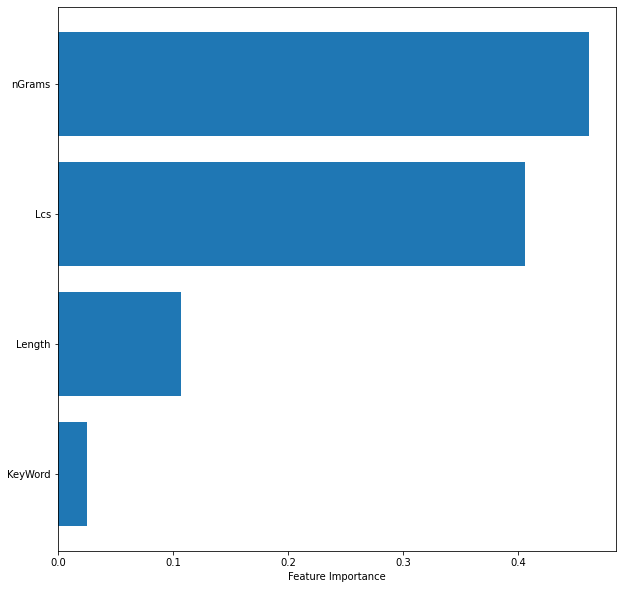

In [243]:
sort = randomForest.feature_importances_.argsort()
plt.figure(figsize=(10, 10))
plt.barh(trainDataSet.columns[sort], randomForest.feature_importances_[sort])
plt.xlabel("Feature Importance")